* PERCOLATION IN COMPLEX SYSTEMS *
==================================

In [2]:
# Load libraries
import os
import sys
import shutil

import graph_tool.all as gt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize":(15, 12)})               # Define plot size

import pdb

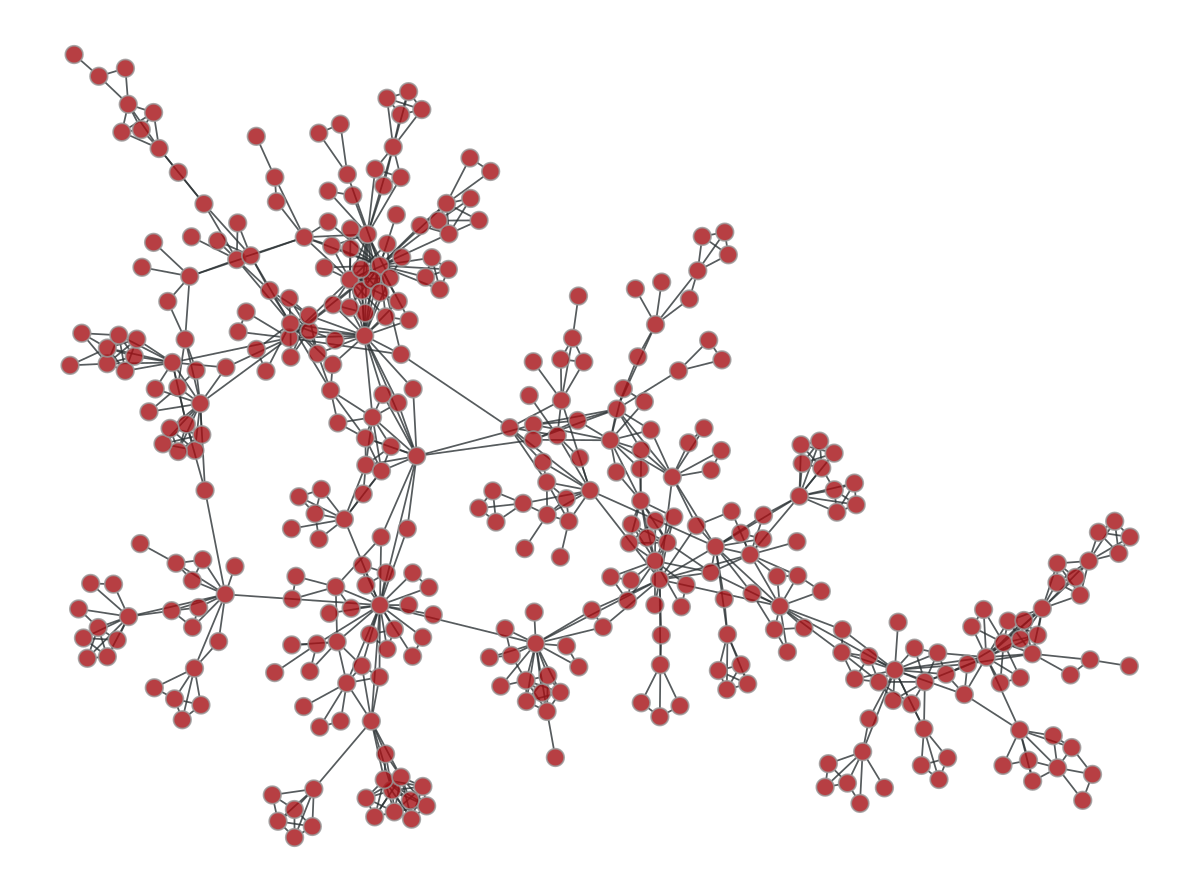

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9cc1f41be0, at 0x7f9c6b7ca8b0>

In [3]:
# Lets load a simple example of a graph (footbal dataset)
graphf = '../datasets/contact.gt.zst'
#g = gt.load_graph(graphf)
gorig = gt.collection.data["netscience"]
gorig = gt.GraphView(gorig, vfilt=gt.label_largest_component(gorig))
g = gt.Graph(gorig, prune = True)

#pos = gt.sfdp_layout(g)
pos2 = g.vp['pos']
gt.graph_draw(g, pos = pos2)


In [4]:
# We can compute some (centrality) trivial measures from this network, such as node-degree and betweeness
# This properties will be saved as a Feature of each node. In graph-tool this means generating a VertexPropertyMap
# We can access such feauters using \networkname\.vp.\featurename (e.g  g.vp.degree)
# More info about PropertyMaps on graph-tool documentation https://graph-tool.skewed.de/static/doc/quickstart.html#property-maps

#PageRank
g.vertex_properties['pagerank'] = gt.pagerank(g)
g.vp.pagerank =  gt.pagerank(g)

# Betweeness
bvp, bep = gt.betweenness(g)
g.vp.betweeness = bvp

# Degree
g.vp.tdegree = g.degree_property_map("total")


In [ ]:
#  We will implement several different (simple) attack/percolation approaches.
#  First, we will start removing only one random node, and see if it has any impact at
#  all in the size of LCC (largest connected components) 
#  The idea is that, the smaller the LCC, the more fragmented the network is
#  and less robust

Plot dummy graph..


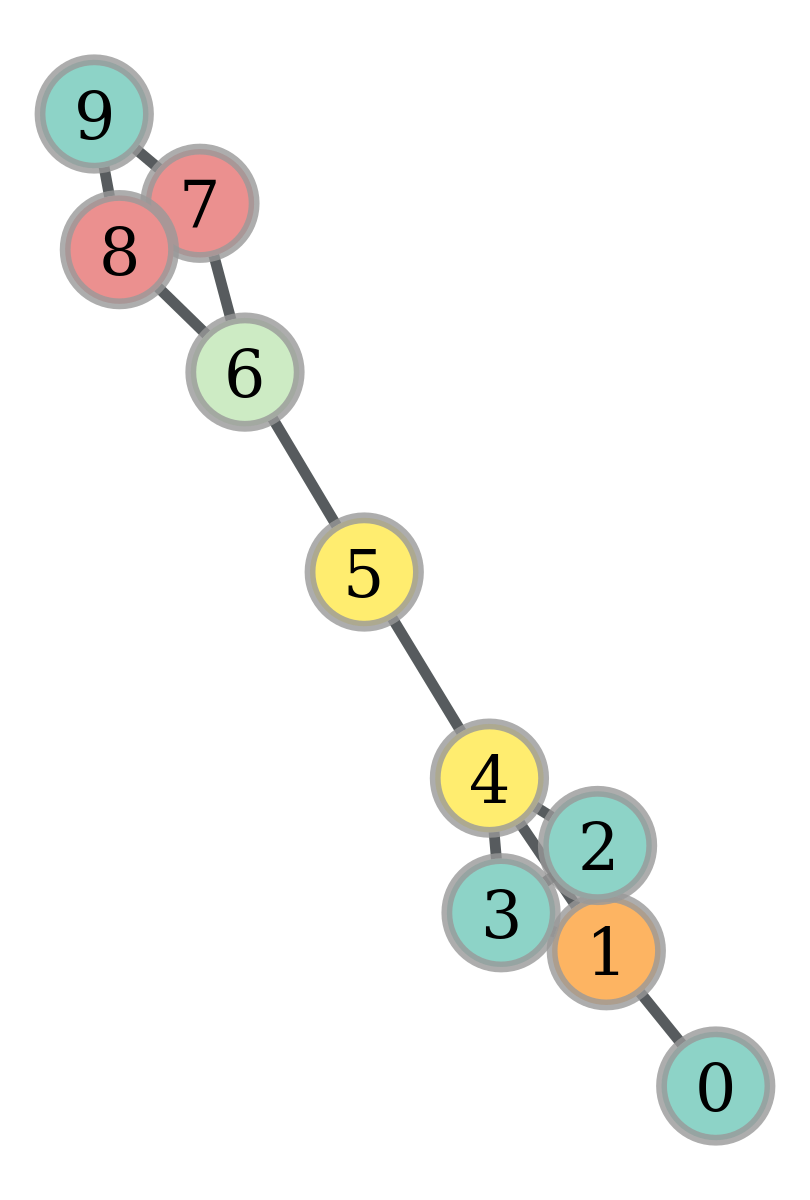

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9c6b7e8be0, at 0x7f9cc4fe0190>

In [5]:
# For tesintg puroposes, it might be useful to know how to generate dummy networks
# Before we start, lets create a dummy graph to control the output
gdummy = gt.Graph(directed = False)
gdummy.add_vertex(10)
gdummy.add_edge(1,0)
gdummy.add_edge(1,2)
gdummy.add_edge(1,3)
gdummy.add_edge(1,4)
gdummy.add_edge(3,2)
gdummy.add_edge(4,2)
gdummy.add_edge(3,4)
gdummy.add_edge(4,5)
gdummy.add_edge(5,6)
gdummy.add_edge(6,7)
gdummy.add_edge(6,8)
gdummy.add_edge(7,8)
gdummy.add_edge(7,9)
gdummy.add_edge(8,9)

gdummy.vp.tdegree = gdummy.degree_property_map("total")
bvp, bep = gt.betweenness(gdummy)
gdummy.vp.betweeness = bvp

'''
Print vertex information (e.g betweeness) 
for v in gdummy.vertices():
    print(gdummy.vp.betweeness[v])
'''

print("Plot dummy graph..")
np.random.seed(42)
pos = gt.fruchterman_reingold_layout(gdummy)    # Simple layout for visualization. There are plenty
gt.graph_draw(gdummy, pos = pos, vertex_fill_color=gdummy.vp.betweeness, vertex_text = gdummy.vertex_index)

< Working with a dummy network >
Size of network:10
Biggest cluster after attacking (some nodes) the network:4


 Now lets attack each one of the nodes of the network and plot the giant component value..
.  Attacking node: 2
.  Attacking node: 3
.  Attacking node: 6
.  Attacking node: 7
.  Attacking node: 0
.  Attacking node: 8
.  Attacking node: 4
.  Attacking node: 5
.  Attacking node: 1
.  Attacking node: 9


 < Working with a real-world network >


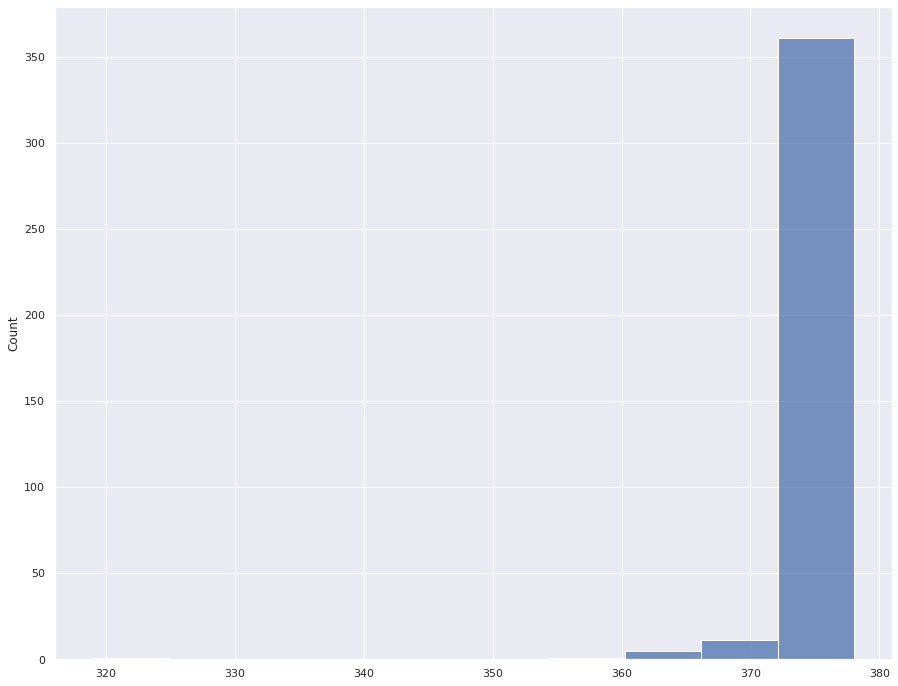

Lets visualize which was the most influential/vulnerable node in the network
Deleting node: 168 lead to a giant cluster of: 319


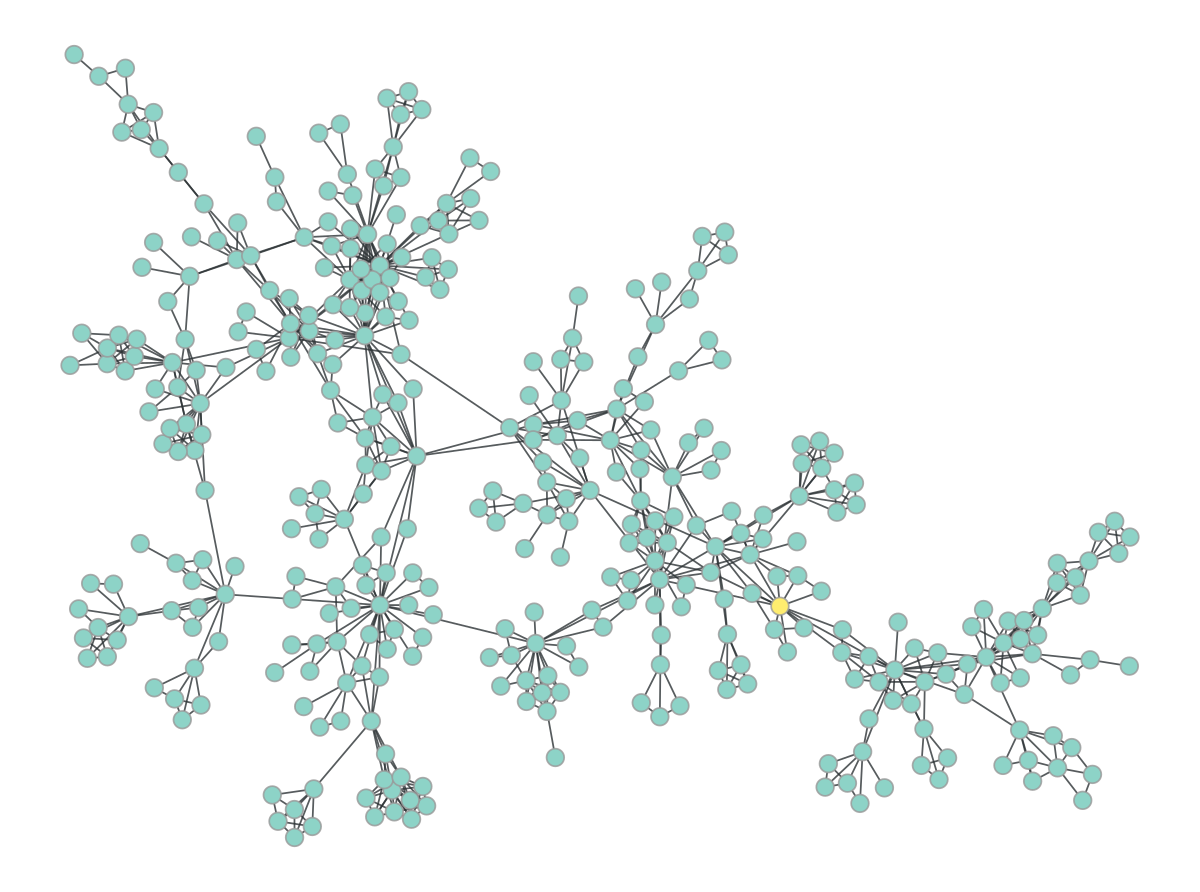

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9cc1f41be0, at 0x7f9c6b7ca8b0>

In [6]:
# RANDOM ATTACK - BRUTE FORCE
# ----------------------------
# Lets start with a random attack (i.e removing one vertex at a time randomly)
# Since our network is not very large, we will iterate over all nodes
# IMPORTANT. To use graph-tool percolation, you MUST pass all the vertex of the graph as a function parameter.
# It will delete (virtually) in the network the LAST vertex of the list, and keep going in reverse order.
print("< Working with a dummy network >")
netsize = gdummy.num_vertices()
print("Size of network:"+str(netsize))
cvertices = np.array([5,0,3,2,1,4])
giant, cmp = gt.vertex_percolation(gdummy,cvertices)
# e.g here it will start deleting the 4th vertex, then the 1st and so on so forth
print("Biggest cluster after attacking (some nodes) the network:"+ str(giant[-2]))


# Lets see what happens when we attack all the nodes of the network randomly
print("\n\n Now lets attack each one of the nodes of the network and plot the giant component value..")
allvertices = [v for v in gdummy.vertices()]             # get all vertices from network
allvertices = np.array(allvertices, dtype="uint64")      # get vertex index
np.random.shuffle(allvertices)                           # shuffle, just for fun
outgiant = np.zeros_like(allvertices)                    #
for idx,pos in enumerate(range(netsize)):
    allvertices = np.roll(allvertices, 1)
    print(".  Attacking node: "+str(allvertices[-1]))
    cgiant, cmp = gt.vertex_percolation(gdummy,allvertices)  # Run percolation  
    outgiant[idx] = cgiant[-2]                               # We get the penultimate value (not last) bc graph-tool include value when non-vertex is deleted
# We can see the distribution/histogram - it doesnt make a lot of sense with just 10 nodes tho
#a = sns.histplot(data = outgiant)


print("\n\n < Working with a real-world network >")
netsize = g.num_vertices()
allvertices = [v for v in g.vertices()]                  # get all vertices from network
allvertices = np.array(allvertices, dtype="uint64")      # get vertex index
np.random.shuffle(allvertices)                           # shuffle, just for fun
outgiant = np.zeros_like(allvertices)                    
attackvertex = np.zeros_like(allvertices)
for idx,pos in enumerate(range(netsize)):
    allvertices = np.roll(allvertices, 1)
    cgiant, cmp = gt.vertex_percolation(g,allvertices)   # Run percolation  
    outgiant[idx] = cgiant[-2]                           # We get the psenultimate value (not last) bc graph-tool include value when non-vertex is deleted
    attackvertex[idx] = allvertices[-1]
    #print(".  Attacking node: "+str(allvertices[-1]) + " resulted into gian cluster size: "+str(cgiant[-2]))
# We can see the distribution/histogram 
sns.histplot(data = outgiant)
plt.show()

# From the histogram it doesnt seem to be very optimal to only attack ONE node in the current network.
# Lets visualize it
print("Lets visualize which was the most influential/vulnerable node in the network")
mingiant = np.min(outgiant)
posmin = np.where(outgiant == mingiant)[0][0]
optatt = attackvertex[posmin]
print("Deleting node: "+str(optatt)+" lead to a giant cluster of: "+str(mingiant))

vulnerable = g.new_vertex_property("int")
g.vp.vuln = vulnerable
g.vp.vuln.a = 1
v = g.vertex(optatt)
g.vp.vuln[v] = 2                     # Assign different name to crucial node
gt.graph_draw(g, pos = pos2, vertex_fill_color=g.vp.vuln)

In [ ]:
# Lets visualize what we refer to with "attacking/percolating different nodes"
# Ofnote, this has been adapted from https://graph-tool.skewed.de/static/doc/demos/animation/animation.html

#Load GTK libraries (to create interface for vieweing)
from gi.repository import Gtk, Gdk, GdkPixbuf, GObject, GLib

# Lets define a propertyMap of the nodes that we will be deleting
state = g.new_vertex_property("vector<double>")


# Lets define colors
itsin = [1., 1., 1., 1.]            # White color
itsout = [0., 0., 0., 1.]           # Black color
itslarge = [0., 1., 0., 1.]         # Green colour

for v in g.vertices():
    state[v] = itsin

if not os.path.exists("./viz/frames"):
    os.makedirs("./viz/frames")

# Lets define the parameters of GTK
win = Gtk.OffscreenWindow()
win.set_default_size(500, 400)

# Lets define the graph and viz parameters
win.graph = gt.GraphWidget(g, pos = pos2,
				edge_color=[0.6, 0.6, 0.6, 1],
				vertex_fill_color=state)

win.add(win.graph)                                       # Add graph to GTK window

# Lets generate some global parameters/variables
allvertices = [v for v in g.vertices()]                  # get all vertices from network
allvertices = np.array(allvertices, dtype="uint64")      # get vertex index
delbool = g.new_vertex_property("bool")                  # Init Boolean Property map

count = 0

# Lets define the function that will be run on loop
def updatePercol():
    global count
    
    # Check if already runned along all the vertices
    # if so, quit the process
    if count >= allvertices.size:
        sys.exit(0)
        
    # Get vertex to percolate/delete
    cdel = g.vertex(count)
        
    # Set default parameters
    for v in g.vertices():
        state[v] = itsin
        delbool[v] = False
        
    # Mark vertex thats being percolated
    state[cdel] = itsout
    
    # LETS START THE PERCOLATION
    # Mark and remove (temporarly) one vertex
    delbool[cdel] = True
    g.set_vertex_filter(delbool, inverted=True)
    
    # Mark largest cluster after removing vertex
    large = gt.label_largest_component(g)
    poslarge = gt.find_vertex(g,large,1)
    for v in poslarge:        
        state[v] = itslarge
    
    # Unset filter (join again graph)
    g.set_vertex_filter(None)
    
    # Compute current largest size
    clarge = np.sum(large.a)
    
    # The following will force the re-drawing of the graph, and issue a
    # re-drawing of the GTK window.
    win.graph.regenerate_surface()
    win.graph.queue_draw()
    
    
    # Save frame
    pixbuf = win.get_pixbuf()
    pixbuf.savev(r'./viz/frames/percolation%06d.png' % count, 'png', [], [])
    
    # Update count
    count += 1
    
    # We need to return True so that the main loop will call this function more
    # than once.
    return True

# Lets initialize the visualization (in background)
# Bind the function above as an 'idle' callback.
cid = GLib.idle_add(updatePercol)

# We will give the user the ability to stop the program by closing the window.
win.connect("delete_event", Gtk.main_quit)

# Actually show the window, and start the main loop.
win.show_all()
Gtk.main()

In [7]:
# Lets create a gif from the results
print("> Generating .gif from previous screenshots")
pngpattern = os.getcwd()+"'/viz/frames/*.png'"
cmd = "ffmpeg -framerate 2 -pattern_type glob -i "+pngpattern+"  ./viz/1-percolation-single-node-attack.gif"
os.system(cmd)

print("> Deleting screenshots..")
shutil.rmtree(os.getcwd()+"/viz/frames")

> Generating .gif from previous screenshots
> Deleting screenshots..


In [ ]:
# Till now, we have only operated in a single-node basis (i.e removing one node at a time)
# However, in order to collapse/attack one system, it might be necesary
# to remove several nodes. This will strongly depend on the density and
# topolgy of the network
# One can visualize how is the influence of removing k-nodes saving the minimum LCC
# for each k-node iteration.
# As a heads up. This will return in a combinatorial problem, which could result into
# very intense (even intratable) computational problem for large networks



 Now lets attack the network using the whole k-nodes combinations..
 Running percolations
 Attacking set of 1 nodes
.  Creating combinatorics of nodes


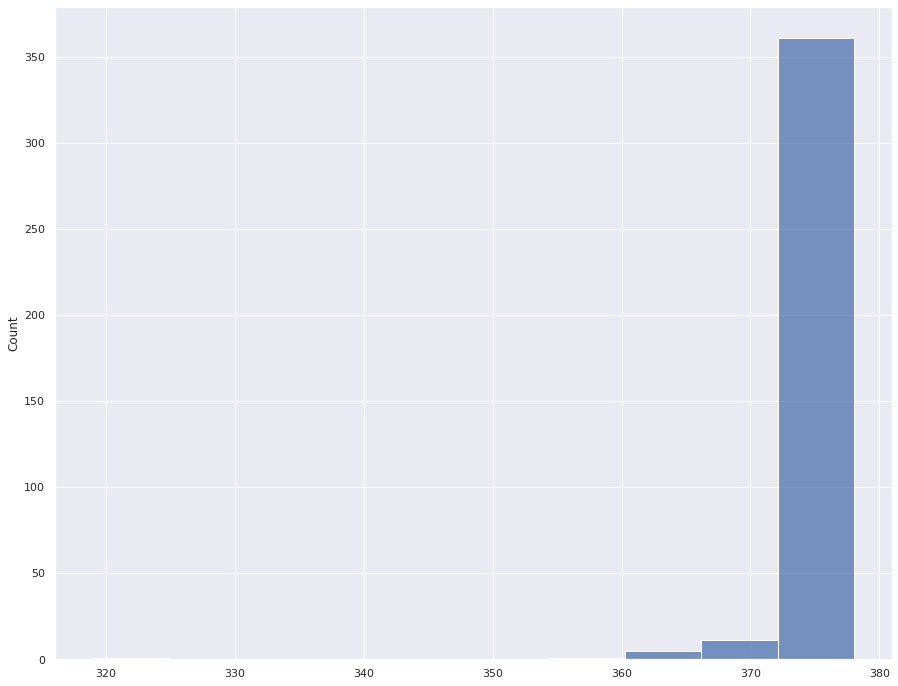

.  Deleting node/s/: (168,) lead to a giant cluster of: 319.0
 Attacking set of 2 nodes
.  Creating combinatorics of nodes


KeyboardInterrupt: 

In [9]:
# RANDOM ATTACK (k-nodes)
# -----------------------
import itertools

# Lets see what happens when we attack all the nodes of the network randomly
print("\n\n Now lets attack the network using the whole k-nodes combinations..")
print('WARNING: THIS MIGHT TAKE A LOT OF TIME FOR BIG NETWORKS')
allvertices = [v for v in g.vertices()]             # get all vertices from network
allvertices = np.array(allvertices, dtype="uint64")      # get vertex index
np.random.shuffle(allvertices)                           # shuffle, just for fun

print(" Running percolations")
for k in range(1,netsize):
    print(" Attacking set of "+str(k)+" nodes")
    
    # Generating combinations/permutations based on k-elements
    print(".  Creating combinatorics of nodes")
    combinatorics = list(itertools.combinations(allvertices, k))
    outgiant = np.zeros(len(combinatorics))  
    
    for idx,comb in enumerate(combinatorics):
        comb = np.array(comb)
        tofill = np.setdiff1d(allvertices,comb)
        topercolate = np.concatenate((tofill,np.array(comb)), axis = 0, dtype="uint64")
        
        cgiant, cmp = gt.vertex_percolation(g,topercolate)  # Run percolation 
        outgiant[idx] = cgiant[-(k+1)]                      # We get the -(k+1) value (not last) bc graph-tool include value when non-vertex is deleted
   
    # Find optimal k-set for percolation
    mingiant = np.min(outgiant)
    posmin = np.where(outgiant == mingiant)[0][0]
    optatt = combinatorics[posmin]
    sns.histplot(data = outgiant)
    plt.show()
    print(".  Deleting node/s/: "+str(optatt)+" lead to a giant cluster of: "+str(mingiant))
    
# We can see the distribution/histogram - it doesnt make a lot of sense with just 10 nodes tho
#a = sns.histplot(data = outgiant)


In [ ]:
# As we mentioned before, the k-node problem might be non-tratable computationaly.
# There are several heuristic algorithim approaches to try to solve this problem
# which can return into close (but non-perfect) solutions.
# Lets visualize the results for some of them!

Lets start the betweeness adaptive attack
here, the idea is that the node with highest betweeness, will be the most vulnerable
We will start attacking from top to bottom. Highest betweeness to lowest betweeness
Creating null-model of random-order percolation
Computing node-betweeness
Attacking based on node-betweeness..


<AxesSubplot:xlabel='Axis', ylabel='value'>

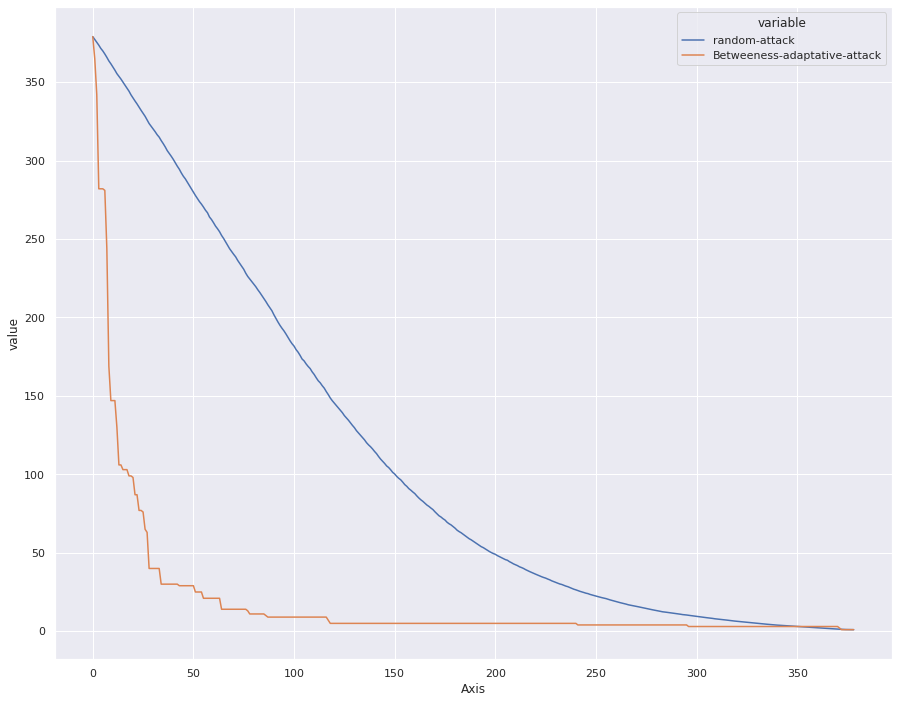

In [9]:
# Heuristic I (High Betweenness Adaptive)
# --------------
print("Lets start the betweeness adaptive attack")
print("here, the idea is that the node with highest betweeness, will be the most vulnerable")
print('We will start attacking from top to bottom. Highest betweeness to lowest betweeness')

if True:
    print("Creating null-model of random-order percolation")
    allvertices = [v for v in g.vertices()]                     # get all vertices from network
    allvertices = np.array(allvertices, dtype="uint64")         # get vertex index
    allverticesr = np.array(allvertices, dtype="uint64")          
    
    numperut = 500
    outpermut = np.zeros([numperut, allverticesr.shape[0]])
    meanpermut = np.zeros_like(allverticesr)
    
    for cperm in range(numperut):
        np.random.shuffle(allverticesr)                          # shuffle randomly
        
        cgiant, cmp = gt.vertex_percolation(g,allverticesr)      # Run percolation         
        outpermut[cperm,:] = cgiant
    
    meanpermut =  np.mean(outpermut, axis = 0)                  # Mean over all random-permutation

    xaxes = np.flip(np.arange(0,allvertices.shape[0],1))       # Define X-axes for plotting
    todf = {'Axis' : xaxes, 'random-attack': meanpermut}       # Define random-based attack
    toplotdf = pd.DataFrame(data = todf)                       # Creating dataframe for plotting seaborn

print("Computing node-betweeness")    
bvp, bep = gt.betweenness(g)
g.vp.betweeness = bvp                     # Save as graph property for future
order = np.argsort(bvp.a)
orderv = allvertices[order]

print("Attacking based on node-betweeness..")
cgiant, cmp = gt.vertex_percolation(g,orderv)      # Run percolation
betweenpercol = cgiant

# Plot curve
toplotdf['Betweeness-adaptative-attack'] = betweenpercol
sns.lineplot(x='Axis', y='value', hue='variable', 
             data=pd.melt(toplotdf, ['Axis']))

Lets start the degree-based attack
here, the idea is that the highest degree node, will be the most vulnerable
We will start attacking from top to bottom. Highest degree to lowest degree
Computing node-degree
Attacking based on node-degree..
Giant cluster of 362 after removing highest degree node 3


<AxesSubplot:xlabel='Axis', ylabel='value'>

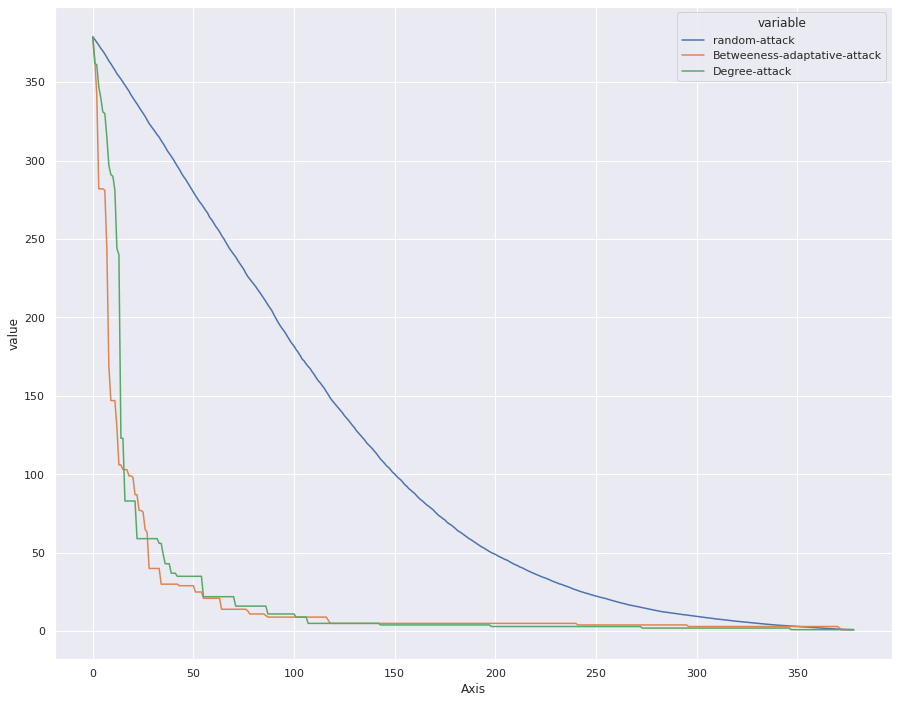

In [10]:
# Heuristic II (Degree-based attack)
# --------------
print("Lets start the degree-based attack")
print("here, the idea is that the highest degree node, will be the most vulnerable")
print('We will start attacking from top to bottom. Highest degree to lowest degree')

if False:
    print("Creating null-model of random-order percolation")
    allvertices = [v for v in g.vertices()]                     # get all vertices from network
    allvertices = np.array(allvertices, dtype="uint64")         # get vertex index
    allverticesr = np.array(allvertices, dtype="uint64")          
    
    numperut = 500
    outpermut = np.zeros([numperut, allverticesr.shape[0]])
    meanpermut = np.zeros_like(allverticesr)
    
    for cperm in range(numperut):
        np.random.shuffle(allverticesr)                          # shuffle randomly
        
        cgiant, cmp = gt.vertex_percolation(g,allverticesr)      # Run percolation         
        outpermut[cperm,:] = cgiant
    
    meanpermut =  np.mean(outpermut, axis = 0)                  # Mean over all random-permutation

    xaxes = np.flip(np.arange(0,allvertices.shape[0],1))       # Define X-axes for plotting
    todf = {'Axis' : xaxes, 'random-attack': meanpermut}
    toplotdf = pd.DataFrame(data = todf)                       # Creating dataframe for plotting seaborn
    
print("Computing node-degree")
nodedegree = g.degree_property_map("total").a
order = np.argsort(nodedegree)
orderv = allvertices[order]

print("Attacking based on node-degree..")
cgiant, cmp = gt.vertex_percolation(g,orderv)      # Run percolation
degreepercol = cgiant

print("Giant cluster of "+str(degreepercol[-2])+" after removing highest degree node "+str(orderv[-1]))

# Plot curve
toplotdf['Degree-attack'] = degreepercol
sns.lineplot(x='Axis', y='value', hue='variable', 
             data=pd.melt(toplotdf, ['Axis']),
             markers=True)

Lets start the module-based betweness attack
here, the idea is that we first compute the modules/blocks of the network using certain algorithm such as:
 Lovian or SBM 

 In this particular case, we will use SBM (peixoto etal 2017) 

Lets compute the optimal partition using SBM..
.  note: This is an bayesian/iterative process. You might get (slight) different results every run
We can visualize each cluster...


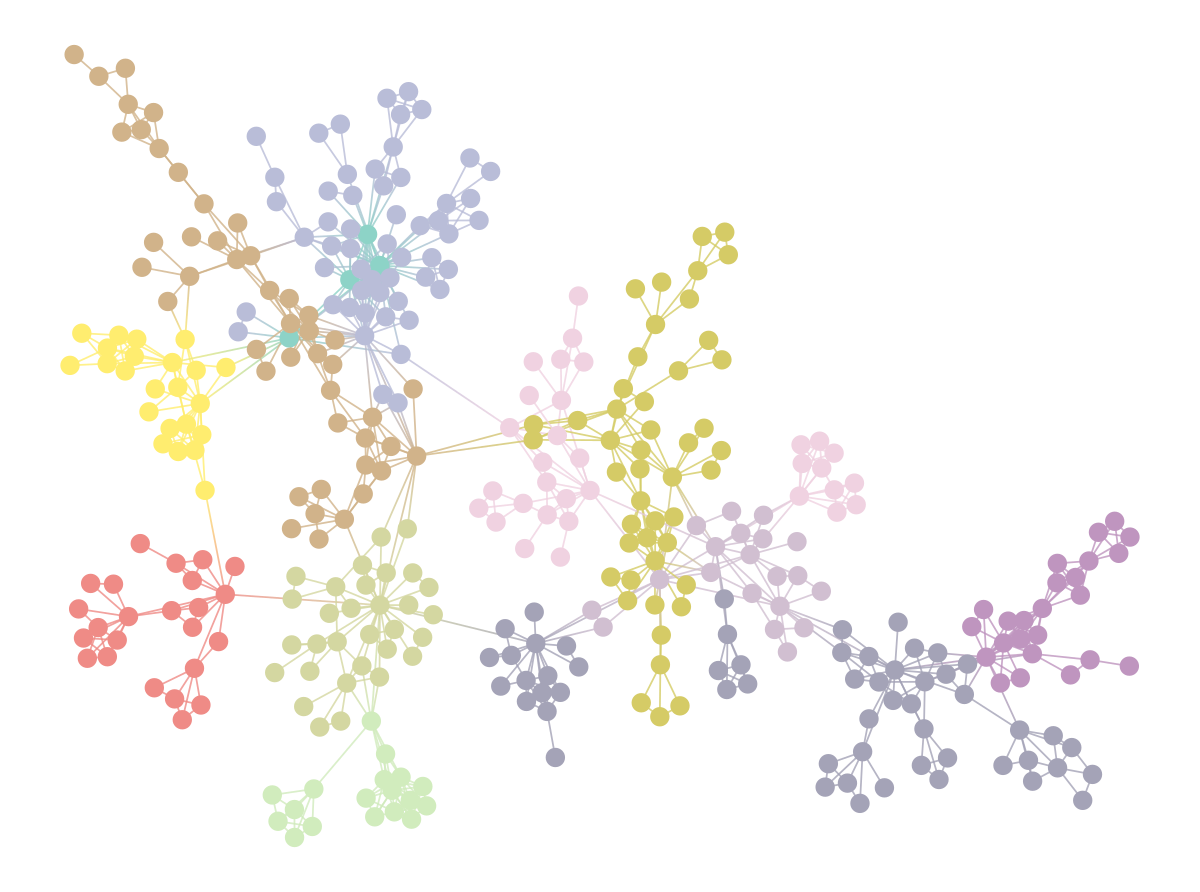

and also the edge-count between modules/clusters...
 

 In order to attack the most module-related vulnerable nodes, we will need to follow some steps 
1) Identify which vertex are module connectors
2) Remove those nodes based on their betweeness
.     note: This could be improved attacking the nodes based on inter-MODULE betweeness, not general betweeness

 Lets detect the inter-module connector nodes
[0, 1, 2, 3, 4, 7, 12, 13, 14, 15, 16, 17, 22, 25, 29, 31, 39, 41, 43, 44, 45, 46, 49, 50, 51, 60, 65, 66, 68, 69, 70, 71, 72, 74, 75, 94, 99, 103, 104, 105, 106, 112, 114, 115, 116, 118, 121, 125, 126, 127, 130, 145, 149, 151, 152, 153, 159, 163, 164, 165, 168, 169, 171, 175, 176, 188, 198, 200, 201, 203, 230, 231, 232, 233, 234, 235, 236, 237, 247, 248, 249, 253, 258, 273, 277, 278, 296, 297, 302, 306, 307, 312, 313, 321, 322, 323, 329, 333, 336, 346, 363, 365, 366, 367, 370, 372, 373]

 .. and plot them ..


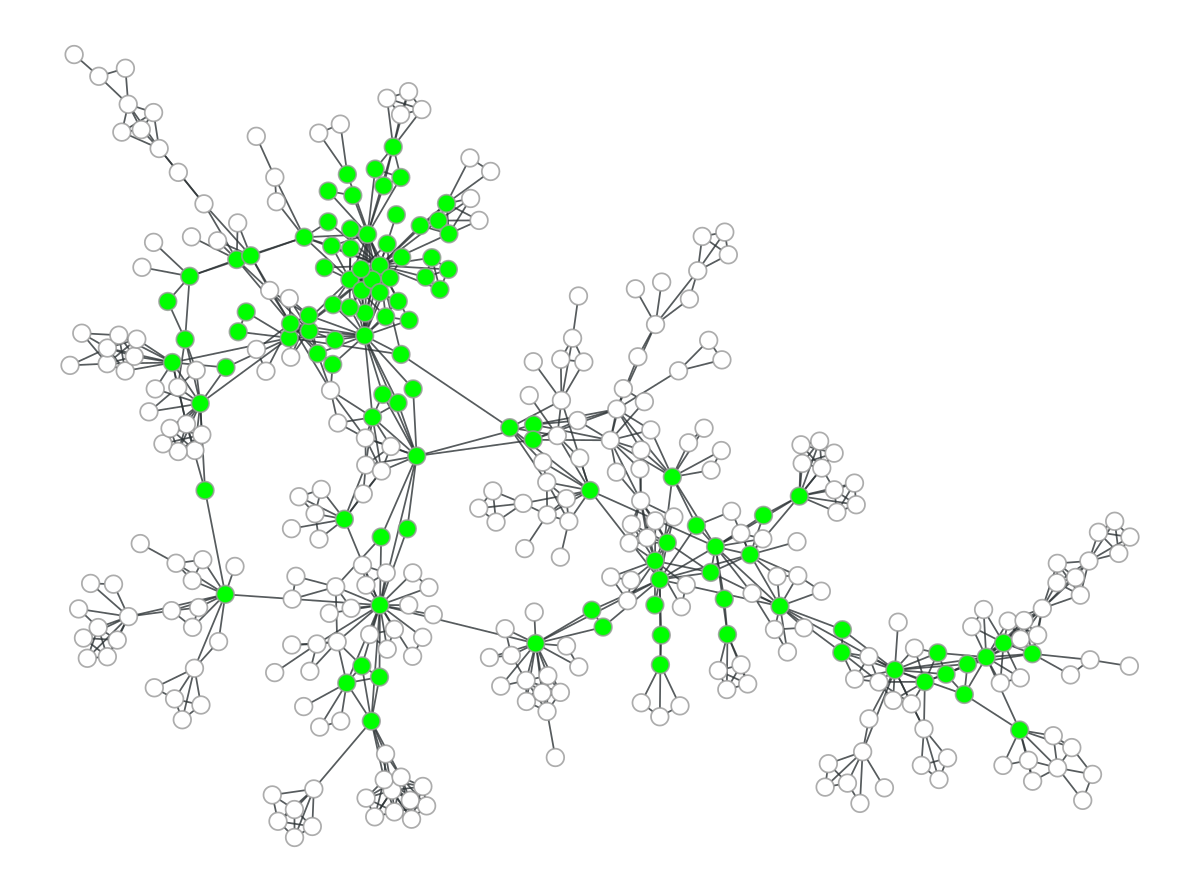


 Lets attack the network based on the modularity-betweeness of these vertex
.  Number of attacking elements: 107
Attacking based on module-interconnecting nodes..


<AxesSubplot:xlabel='Axis', ylabel='value'>

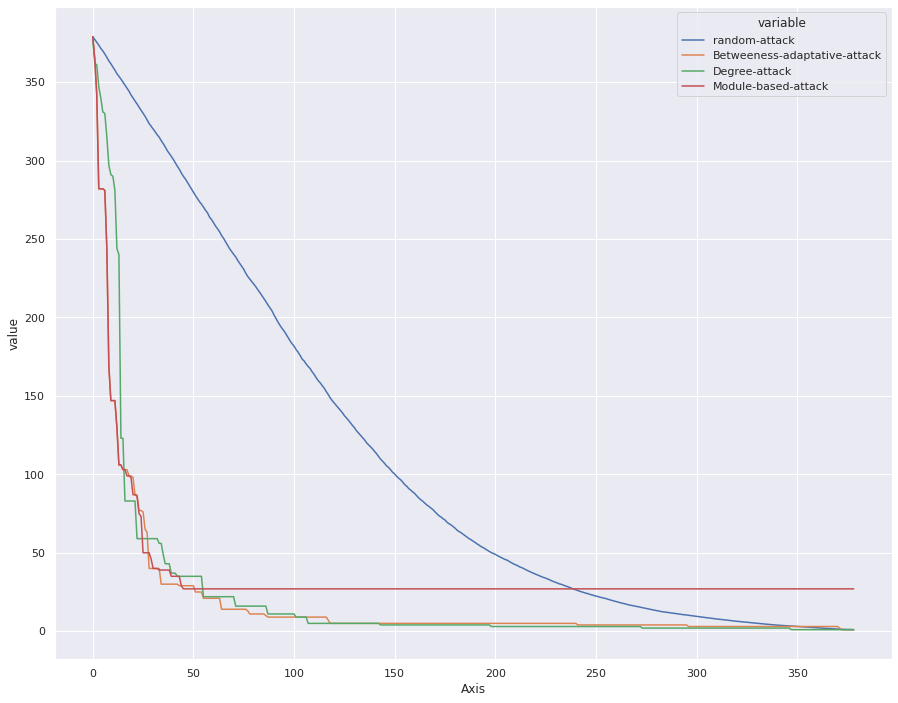

In [13]:
# Heuristic III (Module-Based Attack)
# --------------
print("Lets start the module-based betweness attack")
print("here, the idea is that we first compute the modules/blocks of the network using certain algorithm such as:")
print(" Lovian or SBM \n")

print(" In this particular case, we will use SBM (peixoto etal 2017) \n")

if False:
    print("Creating null-model of random-order percolation")
    allvertices = [v for v in g.vertices()]                     # get all vertices from network
    allvertices = np.array(allvertices, dtype="uint64")         # get vertex index
    allverticesr = np.array(allvertices, dtype="uint64")          
    
    numperut = 500
    outpermut = np.zeros([numperut, allverticesr.shape[0]])
    meanpermut = np.zeros_like(allverticesr)
    
    for cperm in range(numperut):
        np.random.shuffle(allverticesr)                          # shuffle randomly
        
        cgiant, cmp = gt.vertex_percolation(g,allverticesr)      # Run percolation         
        outpermut[cperm,:] = cgiant
    
    meanpermut =  np.mean(outpermut, axis = 0)                  # Mean over all random-permutation

    xaxes = np.flip(np.arange(0,allvertices.shape[0],1))       # Define X-axes for plotting
    todf = {'Axis' : xaxes, 'random-attack': meanpermut}
    toplotdf = pd.DataFrame(data = todf)                       # Creating dataframe for plotting seaborn
    
print("Lets compute the optimal partition using SBM..")
print(".  note: This is an bayesian/iterative process. You might get (slight) different results every run")
clust = gt.minimize_blockmodel_dl(g)
g.vp.module = clust.get_blocks()

print("We can visualize each cluster...")
clust.draw(pos=g.vp.pos)

print("and also the edge-count between modules/clusters...")
e = clust.get_matrix()
tt = e.todense()
#plt.matshow(e.todense())


print(" \n\n In order to attack the most module-related vulnerable nodes, we will need to follow some steps ")
print("1) Identify which vertex are module connectors")
print("2) Remove those nodes based on their betweeness")
print(".     note: This could be improved attacking the nodes based on inter-MODULE betweeness, not general betweeness")

print("\n Lets detect the inter-module connector nodes")
# Search, for each node, if oneof their neighbours are from a different module/block
connectors = []
for cv in g.vertices():
    # Get current vertex module
    cblock = g.vp.module[cv]
    
    # Iterate over neighbours    
    for cneigh in cv.all_neighbors():
        # Check if one of neighbours is from a different block/module
        if g.vp.module[cneigh] != cblock:
            connectors.append(g.vertex_index[cv])
            break
print(connectors)

print("\n .. and plot them ..")
moduleremove = g.new_vertex_property("vector<double>")
# Lets define colors
itsconnector = [0., 1., 0., 1.]     # Green colour
itsnot = [1., 1., 1., 1.]           # white colour
for v in g.vertices():
    moduleremove[v] = itsnot
for v in connectors:
    cv = g.vertex(v)
    moduleremove[v] = itsconnector
# Plot
gt.graph_draw(g, pos = pos2, vertex_fill_color=moduleremove)

print("\n Lets attack the network based on the modularity-betweeness of these vertex")
print(".  Number of attacking elements: "+str(len(connectors)))
# Compute betweeness
bvp, bep = gt.betweenness(g)
g.vp.betweeness = bvp                     # Save as graph property for future
# Order subset of vulnerable nodes based on betweness
betweenconn = bvp.a[connectors]
order = np.argsort(betweenconn)
reorderconn = [connectors[ii] for ii in order]

# Create fake vector to fill attack/vertex list (graph-tool impose to put all vertexs)
allvertices = [v for v in g.vertices()]                     
allvertices = np.array(allvertices, dtype="uint64")         
tofill = np.setdiff1d(allvertices,np.array(reorderconn, dtype="uint64"))
topercolate = np.concatenate((tofill,np.array(reorderconn, dtype="uint64")), axis = 0, dtype="uint64")

print("Attacking based on module-interconnecting nodes..")
cgiant, cmp = gt.vertex_percolation(g,topercolate)      # Run percolation
modulepercol = cgiant

# Since we just have N vertex that were connecting modules, we will set the rest of giant cluster constant
tocte = len(connectors)
lastgiant = modulepercol[-(tocte+1)]
modulepercol[0:-tocte] = lastgiant

# Plot
toplotdf['Module-based-attack'] = modulepercol
sns.lineplot(x='Axis', y='value', hue='variable', 
             data=pd.melt(toplotdf, ['Axis']),
             markers=True)

Lets start the Collective-Influence-based attack
Collective-Influence is an centrality measured that, in addition to specific node-properties,
it takes into account close-by neighbours (restricted by a 'sphere') properties 

The sphere-size (i.e how many steps of neighbours should take into account) is a user-decision parameter 
 Usualy, its between 2-3
 A full description of Collective Influence can be found at: Morone et al 2015 Nature

 There are two different ways to attack the network using CI (and almost every metric):
   1) Compute CI of each node, and attach sequentially
   2) Compute the CI. Choose the biggest one. Remove it. Recompute CI. Loop.

 Lets start computing the first option


Computing Collective Influence with l=2
Attacking based on Collective Influence nodes..


<AxesSubplot:xlabel='Axis', ylabel='value'>

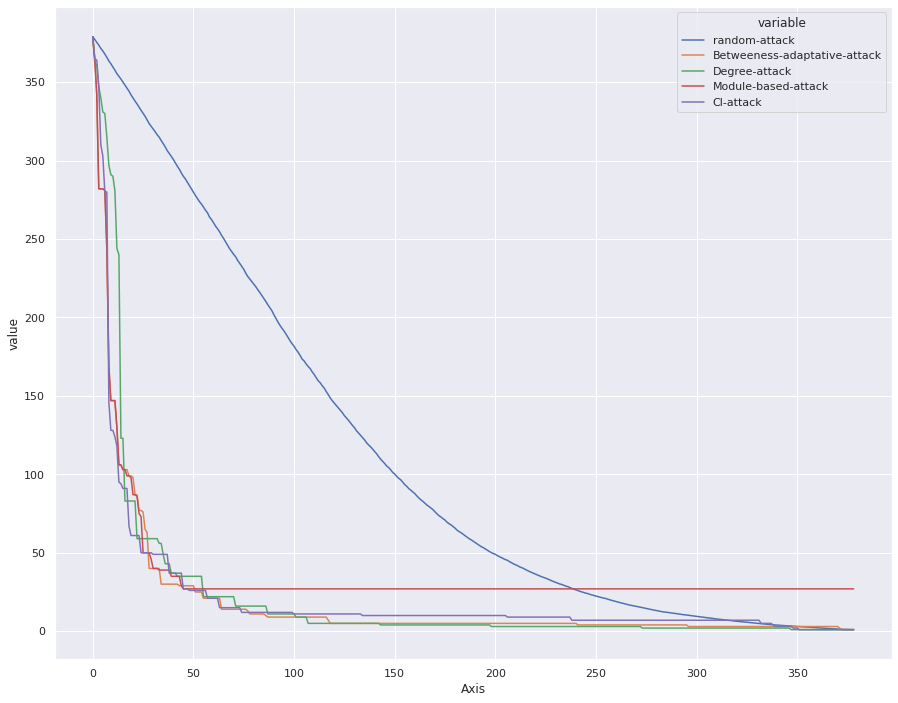

In [16]:
# Attack IV (Collective Influence)
# --------------
print("Lets start the Collective-Influence-based attack")
print("Collective-Influence is an centrality measured that, in addition to specific node-properties,")
print("it takes into account close-by neighbours (restricted by a 'sphere') properties ")
print("\nThe sphere-size (i.e how many steps of neighbours should take into account) is a user-decision parameter ")
print(" Usualy, its between 2-3")
print(" A full description of Collective Influence can be found at: Morone et al 2015 Nature")
print("\n There are two different ways to attack the network using CI (and almost every metric):")
print("   1) Compute CI of each node, and attach sequentially")
print("   2) Compute the CI. Choose the biggest one. Remove it. Recompute CI. Loop.")
print("\n Lets start computing the first option")

if False:
    print("Creating null-model of random-order percolation")
    allvertices = [v for v in g.vertices()]                     # get all vertices from network
    allvertices = np.array(allvertices, dtype="uint64")         # get vertex index
    allverticesr = np.array(allvertices, dtype="uint64")          
    
    numperut = 500
    outpermut = np.zeros([numperut, allverticesr.shape[0]])
    meanpermut = np.zeros_like(allverticesr)
    
    for cperm in range(numperut):
        np.random.shuffle(allverticesr)                          # shuffle randomly
        
        cgiant, cmp = gt.vertex_percolation(g,allverticesr)      # Run percolation         
        outpermut[cperm,:] = cgiant
    
    meanpermut =  np.mean(outpermut, axis = 0)                  # Mean over all random-permutation

    xaxes = np.flip(np.arange(0,allvertices.shape[0],1))       # Define X-axes for plotting
    todf = {'Axis' : xaxes, 'random-attack': meanpermut}       # Define random-based attack
    toplotdf = pd.DataFrame(data = todf)                       # Creating dataframe for plotting seaborn

# Compute Collective Influence
# ----------------
print('\n\nComputing Collective Influence with l=2')
# HELP FROM https://stackoverflow.com/questions/59935241/python-s-graph-tool-generate-egonet-up-n-th-degree


# Define initial Variables
radii = 2
g.vp.ci = g.new_vertex_property("int")
g.vp.cidegree = g.degree_property_map("total").copy()


# Define Functions
# ----------------
def vertexCI(g,vrtx,radii):
    '''
    This function will compute the Collective Vertex for a single vertex/node.
    Implementation based on Monroe etal 2015 Nature
    
    Input:
    -----
       - g      : Network (Graph graph-tool Object)
       - vrtx   : Vertex/Node (Vertex graph-tool Object)
       - radii  : Size of balloon radii (int)
       
    Output:
    -------
       - ci     : Collective Influence value    
    '''
    # vars
    indexvrtx = g.vertex_index[vrtx]
    
    # Find neighbour
    cballoon = gt.shortest_distance(g, vrtx, target=None, max_dist = radii)     # identify all nodes within balloon
    edgeballoon = np.where(cballoon.a == radii)[0]                              #identify boundary baloon
        
    # Filter out edge-balloon-nodes previously excluded (i.e cidegree=0)
    edgeballoon = edgeballoon[g.vp.cidegree.a[edgeballoon] > 0]
    
    # Compute CI
    if g.vp.cidegree.a[indexvrtx] > 0:
        ci = (g.vp.cidegree.a[indexvrtx] - 1) * np.sum(g.vp.cidegree.a[edgeballoon] - 1) # Compute Collective Influence 
    else:
        ci = 0
        
    return ci


# Start the Percolation
# ---------------------
# Compute CI for all nodes in the network
civertices = [v for v in g.vertices()]                     # get all vertices from network
for v in g.vertices():
    cci = vertexCI(g,v,radii)
    g.vp.ci[v] = cci
    
# Perform percolation attack
print("Attacking based on Collective Influence nodes..")
allvertices = [v for v in g.vertices()]                     # get all vertices from network
allvertices = np.array(allvertices, dtype="uint64")         # get vertex index
order = np.argsort(g.vp.ci.a)
orderv = allvertices[order]

cgiant, cmp = gt.vertex_percolation(g,orderv)      # Run percolation
cipercol = cgiant

# Plot curve
toplotdf['CI-attack'] = cipercol
sns.lineplot(x='Axis', y='value', hue='variable', 
             data=pd.melt(toplotdf, ['Axis']),
             markers=True)

Now we will use an heuristic Collective Influence approach (approach #2 previously descrived)
The implementation is based on Morone etal 2016 Sci Reports

Computing Heuristic Collective Influence with l=2
Iteratively compute Collective influence for each vertex in the network
Attacking based on Heuristic Collective Influence nodes..


<AxesSubplot:xlabel='Axis', ylabel='value'>

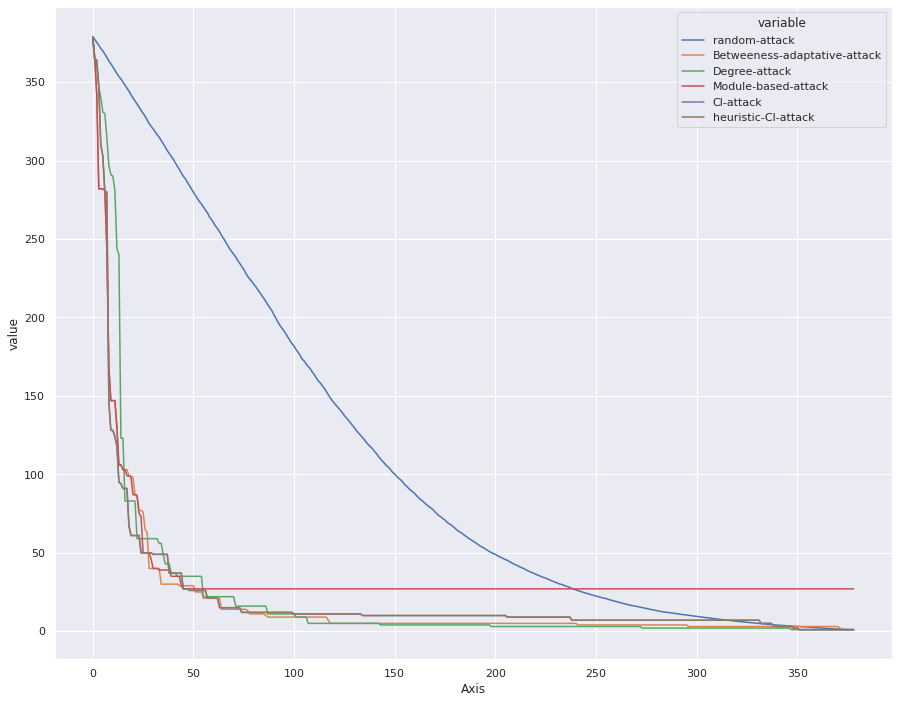

In [17]:
# Attack IV (Heuristic Collective Influence)
# --------------
print("Now we will use an heuristic Collective Influence approach (approach #2 previously descrived)")
print("The implementation is based on Morone etal 2016 Sci Reports")

# Compute Collective Influence
# ----------------
print('\nComputing Heuristic Collective Influence with l=2')
# HELP FROM https://stackoverflow.com/questions/59935241/python-s-graph-tool-generate-egonet-up-n-th-degree


# Define initial Variables
radii = 2
g.vp.ci = g.new_vertex_property("int")
g.vp.cidegree = g.degree_property_map("total").copy()


# Define Functions
# ----------------
def updateCI(g, vrtx, radii):
    """
    This function will update the CI value after removing one node/vertex.
    It will also update the  cidegree PropertyMap, in order to exclude such node from further computation
    Implementation based on Morone etal 2016 Sci Reports
    
    Input:
    ------
       - g      : Network (Graph graph-tool Object)
       - vrtx   : Vertex/Node (Vertex graph-tool Object)
    """
    # Vars
    indexvrtx = g.vertex_index[vrtx]
   
    # Set node cidegree to zero
    g.vp.cidegree.a[indexvrtx] = 0
    
    # Update neighbours cidegree (i.e we removed one node, we have to update their degree)
    cballoon = gt.shortest_distance(g, vrtx, target=None, max_dist = radii)  
    neighbours = np.where(cballoon.a == 1)[0] 
    g.vp.cidegree.a[neighbours] -= 1
    g.vp.cidegree.a[g.vp.cidegree.a < 0] = 0     # Dont allow negative degree
    pdb.set_trace
    
    # Update CI from nodes in the balloon (i.e we removed one node within the ballon. All vertices will notice it.)
    balloonpos = np.where(cballoon.a <= radii)[0] 
    for v in balloonpos:
        cv = g.vertex(v)
        cci = vertexCI(g,cv,radii)
        g.vp.ci[cv] = cci
        
    return

# Start the Percolation
# ---------------------
# Compute CI for all nodes in the network
civertices = [v for v in g.vertices()]                     # get all vertices from network
for v in g.vertices():
    cci = vertexCI(g,v,radii)
    g.vp.ci[v] = cci
    
# Iteratively compute N times the top CI
# Here, at every step, will determine the top CI, update rest of network CI, loop.
print("Iteratively compute Collective influence for each vertex in the network")
nodeorder = np.zeros([g.num_vertices()], dtype = int)
ciordered = np.zeros([g.num_vertices()], dtype = int)
for it in range(0,g.num_vertices()):
    # Find top CI vertex
    topvrtx = np.where(g.vp.ci.a == np.max(g.vp.ci.a))[0]
    
    # Stop searching if non node has CI > 0
    if np.max(g.vp.ci.a) < 1:
        break
    
    # If multiple top-nodes, choose one with highest degree (victor homemade decision xd)
    if topvrtx.size > 1:
        topdegree = np.where(g.vp.cidegree.a[topvrtx] == np.max(g.vp.cidegree.a[topvrtx]))[0][0]
        topvrtx = topvrtx[topdegree]
                                                                                                   
    # Save node in percolation list
    nodeorder[-it-1] = topvrtx         # We place it the last one, since graph-tool percolation attack inverse order
    ciordered[-it-1] = np.max(g.vp.ci.a)
    
    # Update CI of topvertex
    topvrtx = g.vertex(topvrtx)   # Obtain Vertex Object
    updateCI(g, topvrtx, radii)

# Perform percolation attack
print("Attacking based on Heuristic Collective Influence nodes..")
cgiant, cmp = gt.vertex_percolation(g,orderv)      # Run percolation
heuristci = cgiant

# Plot curve
toplotdf['heuristic-CI-attack'] = heuristci
sns.lineplot(x='Axis', y='value', hue='variable', 
             data=pd.melt(toplotdf, ['Axis']),
             markers=True)


In [ ]:
# Heuristic V (Modularity Vitality)
# --------------
'''
Pending
toDo
Lazy-author

'''

In [ ]:
'''
Another possible solution is to determine the most crucial nodes and start attacking them, followed by their neighbours and so on.
The idea will be check: how many steps of neighbours are needed to arrive
to a critical point.
This could be plot using a plane (i.e 3-D plot)
The idea is somehow similar to CI, but we force to attack the neighbours, instead of going to the next top-CI
'''